# CSE 572: Lab 13

In this lab, you will practice implementing techniques for dimensionality reduction using Kernel PCA and autoencoder neural networks.

To execute and make changes to this notebook, click File > Save a copy to save your own version in your Google Drive or Github. Read the step-by-step instructions below carefully. To execute the code, click on each cell below and press the SHIFT-ENTER keys simultaneously or by clicking the Play button. 

When you finish executing all code/exercises, save your notebook then download a copy (.ipynb file). Submit the following **three** things:
1. a link to your Colab notebook,
2. the .ipynb file, and
3. a pdf of the executed notebook on Canvas.

To generate a pdf of the notebook, click File > Print > Save as PDF.

## Kernel PCA

Principal component analysis (PCA) is a classical method for reducing the dimensionality (number of attributes) in the data by projecting the data from its original high-dimensional space into a lower-dimensional space. The conventional formulation of PCA is limited to finding a linear projection of the data, so if the original data are not linearly separable then the PCA-projected data also will not be. Kernel PCA is a simple modification of PCA that uses kernel functions to project data into a higher-dimensional space where it may become linearly separable and compute PCA in the higher-dimensional space, using special kernel functions to make this computation feasible.

In this section, we will apply Kernel PCA to the same image dataset from Lab 11 and compare the results to linear PCA.

### Load the dataset

We will use a preprocessed subset of the “Labeled Faces in the Wild” (LFW) dataset, which you can read more about [here](http://vis-www.cs.umass.edu/lfw/).

In [34]:
from sklearn.datasets import fetch_lfw_people

lfw_people = fetch_lfw_people(min_faces_per_person=70)

# data attribute gives the data matrix with the image dimension flattened
X = lfw_people.data
print('Num samples: {}'.format(X.shape[0]))
print('Num features: {}'.format(X.shape[1]))

# images attribute gives the unflattened image dimension
print('Image dimensions: {} x {}'.format(lfw_people.images.shape[1], lfw_people.images.shape[2]))

# the label to predict is the id of the person
y = lfw_people.target
# target_names attribute tells us the name of the person associated with each id
target_names = lfw_people.target_names
n_classes = target_names.shape[0]
print('Num classes: {}'.format(n_classes))
print('Class names:', target_names)

Num samples: 1288
Num features: 2914
Image dimensions: 62 x 47
Num classes: 7
Class names: ['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Tony Blair']


The dataset has 1,288 images of the faces of 7 different people. The code below prints the number of samples from each class.

In [35]:
for i in range(n_classes):
    print('Number of instances in class {} ({}): {}'.format(i,
                                                            target_names[i],
                                                            y[y==i].shape[0]
                                                           ))

Number of instances in class 0 (Ariel Sharon): 77
Number of instances in class 1 (Colin Powell): 236
Number of instances in class 2 (Donald Rumsfeld): 121
Number of instances in class 3 (George W Bush): 530
Number of instances in class 4 (Gerhard Schroeder): 109
Number of instances in class 5 (Hugo Chavez): 71
Number of instances in class 6 (Tony Blair): 144


To get an idea of what is in our dataset, we visualize a random face from each class below. (Note: You can run this cell many times to see different random examples.)

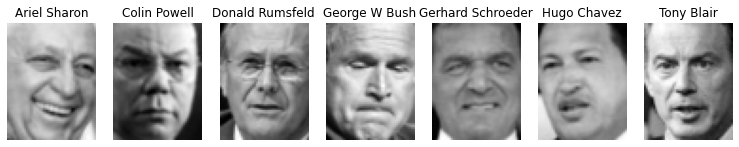

In [36]:
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(ncols=n_classes, figsize=(13,6))

for i in range(n_classes):
    rand_ind = np.random.randint(0, y[y==i].shape[0])
    axes[i].imshow(lfw_people.images[y==i][rand_ind], cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(target_names[i])

Next, we will split the data into training and test subsets, using 30\% of the data for testing.

In [37]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

Next we standardize the data so that the mean of all attributes is 0 using the StandardScaler() object in scikit-learn to standardize the data. We fit the scaler to the training data and apply it to both the training and test data.

In [38]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Kernel PCA

Kernel PCA uses one of several choices of kernel functions to transform the data into a higher-dimensinoal space and then compute the principal components (eigenvectors) of the data in the high-D space. We then use these principal components to transform the data into a new set of features that maximizes variance in the dataset. 

The KernelPCA class in scikit-learn gives four options for kernel functions (the same functions available for SVM): 'poly', 'rbf', 'sigmoid', and 'cosine'. In the code below, we implement KernelPCA using 10 principal components and the sigmoid kernel.

In [39]:
from sklearn.decomposition import KernelPCA

n_components = 10

kpca = KernelPCA(n_components=n_components, kernel='sigmoid', fit_inverse_transform=True).fit(X_train)

We can use our PCA model (i.e., the principal component vectors found in our data) to transform our dataset into the new reduced-dimensional space. This is done in the below code using the `transform()` function.

In [40]:
X_train_kpca = kpca.transform(X_train)
X_test_kpca = kpca.transform(X_test)

### SVM classifier with Kernel PCA

Now that we've reduced the dimensionality of our dataset from 2914 to 10, we can use these new features as our inputs for classification. In this example, we'll use a Support Vector Machine (SVM) classifier. In the cell below, train an SVM with `C=10000` and `kernel='rbf'`.

In [41]:
from sklearn.svm import SVC

clf = SVC(C=10, kernel='rbf')
clf = clf.fit(X_train_kpca, y_train)

In the cell below, use the trained model to make predictions for the test set.

In [42]:
y_pred = clf.predict(X_test_kpca)

The next cell shows how we can use the `classification_report()` function in sklearn to print several metrics computed for the test set. 

In [43]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.17      0.11      0.13        18
     Colin Powell       0.51      0.62      0.56        69
  Donald Rumsfeld       0.44      0.47      0.46        34
    George W Bush       0.67      0.74      0.70       166
Gerhard Schroeder       0.32      0.23      0.26        31
      Hugo Chavez       0.24      0.21      0.22        19
       Tony Blair       0.45      0.28      0.35        50

         accuracy                           0.54       387
        macro avg       0.40      0.38      0.38       387
     weighted avg       0.52      0.54      0.52       387



We can also use the `ConfusionMatrixDisplay` object to visualize the confusion matrix for the test set predictions.

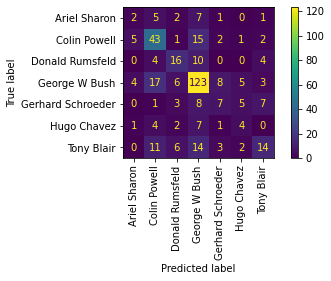

In [44]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(
    clf, X_test_kpca, y_test, display_labels=target_names, xticks_rotation="vertical"
)

plt.tight_layout()
plt.show()

**Question 1: What is the difference between the covariance matrix and the confusion matrix? What are the dimensions of each in terms of the number of attributes (m) and the number of classes (c)? How are each used here?**

**Answer:**

YOUR ANSWER HERE

a) The confusion matrix measures a classification model's effectiveness, while the covariance matrix gauges the relationship between pairs of variables. Whereas machine learning uses the confusion matrix, statistics uses the covariance matrix. Both matrices are employed for various purposes and have many applications.

b) Dimensions: 
    1. Covariance Matrix: [m x m] \
    2. Confusion Matrix: [c x c]

c) Confusion Matrix shows how predications were classified or catagorized and Covaiance Matrix used to reduce dimensionality.



### Data reconstruction

We can reconstruct the original input images by multiplying the encoded data in the principal subspace by the principal component vectors. This reverse transformation is called the *inverse transform*. The code below reconstructs the original data using the KernelPCA `inverse_transform()` function.

In [45]:
train_recon_kpca = kpca.inverse_transform(X_train_kpca)
test_recon_kpca = kpca.inverse_transform(X_test_kpca)

Create a plot to visualize the original image and reconstructed image for the first 5 images in the test set. Plot the original images on the first row and the reconstructions on the second row. Print the class name as the title for each original image and turn off the axis labels/tickmarks (as in the earlier face visualization from this lab).

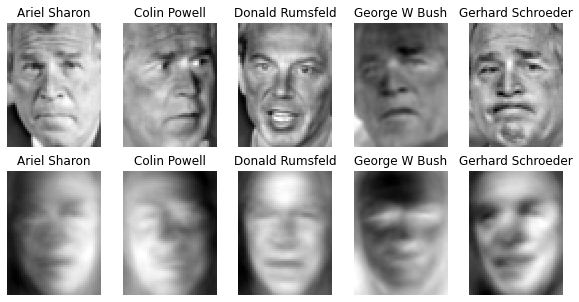

In [46]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(10,5))
n_images = 5

# YOUR CODE HERE
img_shape = [lfw_people.images.shape[1], lfw_people.images.shape[2]]


for i in range(n_images):
    test_img = np.reshape(X_test[i], img_shape)
    recon_img = np.reshape(test_recon_kpca[i], img_shape)
    
    axes[0][i].imshow(test_img, cmap='gray')
    axes[0][i].set_title(target_names[i])
    axes[0][i].axis('off')
 
    axes[1][i].imshow(recon_img, cmap='gray')
    axes[1][i].set_title(target_names[i])
    axes[1][i].axis('off')


In Lab 11, we used linear PCA to reduce the data dimensionality and use the transformed data as the input to SVM as we did in Lab 12 with KernelPCA. However, in Lab 11 we did not reconstruct the original data from the principal subspace as we did above with KernelPCA. 

In the cell(s) below, fit a new linear PCA model with 10 principal components (same as was done in Lab 11). Then, plot the above visualization again, but this time add a third row for the same images reconstructed using linear PCA.

In [47]:
# YOUR CODE HERE

from sklearn.decomposition import PCA

num_components = 10

pca = PCA(n_components=num_components)

pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)


In [48]:
# YOUR CODE HERE
train_recon_pca = pca.inverse_transform(X_train_pca)
test_recon_pca = pca.inverse_transform(X_test_pca)

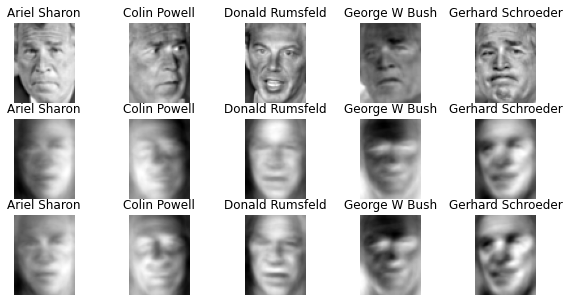

In [49]:
fig, axes = plt.subplots(ncols=5, nrows=3, figsize=(10,5))
n_images = 5
img_shape = [lfw_people.images.shape[1], lfw_people.images.shape[2]]

for i in range(n_images):
    # Test images
    test_img = np.reshape(X_test[i], img_shape)
    axes[0][i].imshow(test_img, cmap='gray')
    axes[0][i].set_title(target_names[i])
    axes[0][i].axis('off')
    
    # Reconstructed kPCA images
    kpca_img = np.reshape(test_recon_kpca[i], img_shape)
    axes[1][i].imshow(kpca_img, cmap='gray')
    axes[1][i].set_title(target_names[i])
    axes[1][i].axis('off')
    
    # Reconstructed PCA images
    pca_img = np.reshape(test_recon_pca[i], img_shape)
    axes[2][i].imshow(pca_img, cmap='gray')
    axes[2][i].set_title(target_names[i])
    axes[2][i].axis('off')


## Autoencoder neural network

An autoencoder is a type of neural network in which the outputs are the same as the inputs. In other words, the goal of the network is to reconstruct the original input image by minimizing the mean squared error loss function. The autoencoder consists of two main components: an encoder network that maps the input data to a low dimensional representation $z$ and a decoder network that maps $z$ back to the original dimension. 

In the code below, we implement a simple autoencoder network using dense (feed-forward) layers and train it using our LFW faces dataset.

In [50]:
import tensorflow as tf
seed = 256
tf.keras.utils.set_random_seed(seed)

import keras
from keras import layers

# This is the size of our encoded representations
encoding_dim = 32  

# This is our input image
input_img = keras.Input(shape=(X_train.shape[1],))
# "encoded" is the encoded representation of the input
encoded = layers.Dense(128, activation='relu')(input_img)
encoded = layers.Dense(64, activation='relu')(encoded)
encoded = layers.Dense(encoding_dim, activation='relu')(encoded)

# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(64, activation='relu')(encoded)
decoded = layers.Dense(128, activation='relu')(decoded)
decoded = layers.Dense(X_train.shape[1], activation='sigmoid')(decoded)

# This model maps an input to its reconstruction
autoencoder = keras.Model(input_img, decoded)

In addition to the full autoencoder model, we can construct the encoder and decoder models separately. Here we will construct the encoder model so that we can use it to reduce the data dimensionality without having to also reconstruct the data (which is done by `autoencoder`).

In [51]:
# This model maps an input to its encoded representation
encoder = keras.Model(input_img, encoded)

Next we compile the model. We'll use the Adam optimizer and mean squared error loss.

In [52]:
autoencoder.compile(optimizer='adam', loss='mse')

Now we train our model. Below we train for 100 epochs using a batch size of 32. 

In [53]:
autoencoder.fit(x=X_train, y=X_train,
                epochs=100,
                batch_size=32,
                shuffle=True)

Epoch 1/100
29/29 [==============================] - 2s 15ms/step - loss: 1.0001
Epoch 2/100
29/29 [==============================] - 0s 15ms/step - loss: 0.8792
Epoch 3/100
29/29 [==============================] - 0s 14ms/step - loss: 0.8180
Epoch 4/100
29/29 [==============================] - 0s 15ms/step - loss: 0.7921
Epoch 5/100
29/29 [==============================] - 0s 14ms/step - loss: 0.7790
Epoch 6/100
29/29 [==============================] - 0s 14ms/step - loss: 0.7677
Epoch 7/100
29/29 [==============================] - 0s 14ms/step - loss: 0.7577
Epoch 8/100
29/29 [==============================] - 0s 14ms/step - loss: 0.7474
Epoch 9/100
29/29 [==============================] - 0s 15ms/step - loss: 0.7396
Epoch 10/100
29/29 [==============================] - 0s 14ms/step - loss: 0.7350
Epoch 11/100
29/29 [==============================] - 0s 14ms/step - loss: 0.7337
Epoch 12/100
29/29 [==============================] - 0s 14ms/step - loss: 0.7287
Epoch 13/100
29/29 [=====

**Question 2: In the code above, why did we set x and y both equal to `X_train`?**

**Answer:**

YOUR ANSWER HERE \

For the reason that the auto encoder compresses the input before regenerating it as output. Thus, we pass y as X train.

Now we have our trained autoencoder for which the input is an image and the output is the reconstruction. Next we use our trained autoencoder to reconstruct the test images.

In [54]:
test_recon_ae = autoencoder.predict(X_test)

13/13 [==============================] - 0s 7ms/step


In the cell below, visualize the same 5 as we did for KernelPCA and linear PCA. You can copy the same code as the previous code block used for visualization and add a fourth row for the autoencoder reconstructions.

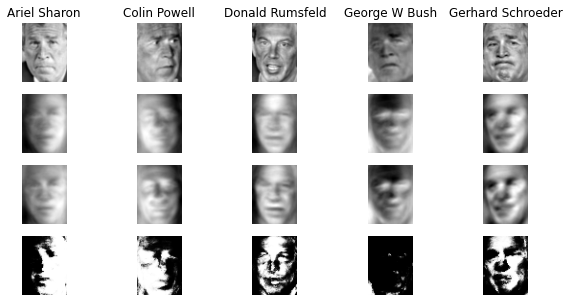

In [55]:
fig, axes = plt.subplots(ncols=5, nrows=4, figsize=(10,5))
n_images = 5
img_shape = [lfw_people.images.shape[1], lfw_people.images.shape[2]]

for i in range(n_images):
    # Test images
    test_img = np.reshape(X_test[i], img_shape)
    axes[0][i].imshow(test_img, cmap='gray')
    axes[0][i].set_title(target_names[i])
    axes[0][i].axis('off')
    axes  
    # Reconstructed kPCA images
    kpca_img = np.reshape(test_recon_kpca[i], img_shape)
    axes[1][i].imshow(kpca_img, cmap='gray')
    axes[1][i].axis('off')
    
    # Reconstructed PCA images
    pca_img = np.reshape(test_recon_pca[i], img_shape)
    axes[2][i].imshow(pca_img, cmap='gray')
    axes[2][i].axis('off')
    
    # Reconstructed AE images
    ae_img = np.reshape(test_recon_ae[i], img_shape)
    axes[3][i].imshow(ae_img, cmap='gray')
    axes[3][i].axis('off')
    

**Question 3: The reconstructions by the autoencoder do not look as accurate as the reconstructions by the PCA and KernelPCA models. This does not mean that linear or kernel PCA is inherently better than an autoencoder for reducing the dimensionality of this dataset---it is probable that if we spent time tuning all the hyperparameters of the autoencoder, we would find a model that has a better solution. However, there are many more hyperparameters to tune in the autoencoder compared to the PCA models. List at least three hyperparameters that could be optimized for the autoencoder.**

**Answer:**

YOUR ANSWER HERE

1. Number of nodes in hidden layer
2. Loss function
3. Epochs
4. Activation Functions
5. Learning rate

**Question 4: The autoencoder we implemented here used feed-forward/dense layers. Another way to improve the autoencoder reconstruction could be to use a different type of layer. What other type of layer might give better performance (e.g., convolutional, recurrent) and why?**

**Answer:**

YOUR ANSWER HERE

As the convolutional layer maintains the correlation while using a kernel to identify significant features in the image, I believe it may have provided superior performance. The analysis of text and speech is better suited to recurrent layers.

Convolutional layers may improve performance in the autoencoder, particularly for image data. Convolutional layers can efficiently encode the key components of a picture since they are built to capture spatial patterns. 

The model can more effectively capture the spatial information in the input image by utilizing convolutional layers in the encoder section of the autoencoder. 